# Deep Q-learning

Here I try to implement the Reinforcement Learning technique called Deep Q-learning (or Deep Q-Network, hence DQN) which uses a Neural Network (in our case will be a Parametrized Quantum Circuit) to approximate the Q-values.

This is the same technique used in the paper by Skolik. 

I will mostly copy the code from this great book *Hands on Machine Learning*, which has accompanying free tutorials here:  
https://github.com/ageron/handson-ml2

#### Import of relevant packages

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Qiskit Operator imports
from qiskit.aqua.operators import Z, I, StateFn, CircuitStateFn, SummedOp
from qiskit.aqua.operators.gradients import Gradient, NaturalGradient, QFI, Hessian

# Qiskit Circuit imports
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ParameterExpression
from qiskit.circuit.library import TwoLocal

# Qiskit imports
import qiskit as qk
from qiskit.utils import QuantumInstance

# Qiskit Machine Learning imports
import qiskit_machine_learning as qkml
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector

# PyTorch imports
import torch
from torch import Tensor
from torch.nn import MSELoss
from torch.optim import LBFGS, SGD, Adam, RMSprop

# OpenAI Gym import
import gym

# Fix seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

In [2]:
# To get smooth animations
import matplotlib as mpl
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

### Definition of the *Parametrized Quantum Circuit* (PQC)  

##### `encoding_circuit` & `parametrized_circuit`  

1. First, the `encoding circuit`, used to load on the circuit the classical inputs. In our case, the inputs are the state variables of the environment. In the present version, the code is suited for the `Cart-Pole` environment, or other with continuous states.  

2. The `parametrized_circuit` function creates the full parametrized quantum circuit, with inputs and weights (trainable parameters) given as Qiskit's `Parameters`. It is possible to choose the number of repetitions (*layers*) in the quantum circuit, as well as wether to use data *reuploading*.

In [3]:
def encoding_circuit(inputs, num_qubits = 4, gate = 'rx', *args):
    """
    Encode classical input data on a quantum circuit. 
    
    To be used inside the `parametrized_circuit` function. 
    
    Args
    -------
    
    Return
    -------
    
    
    TODO:
    1. Add choice of encoding gate: ry, rz, or rx.
    """
    
    qc = qk.QuantumCircuit(num_qubits)
    
    # Encode data with a RX rotation
    for i, data in enumerate(inputs): 
        qc.rx(inputs[i], i)
        
    return qc

def parametrized_circuit(num_qubits = 4, reuploading = False, reps = 2, insert_barriers = True, meas = False):
    """
    Create the Parameterized Quantum Circuit (PQC) for estimating Q-values.
    It is the same reported in arXiv:2104.15084 (Skolik et al.).
    
    Args
    -------
    
    Return
    -------
    """
    
    qr = qk.QuantumRegister(num_qubits, 'qr')
    qc = qk.QuantumCircuit(qr)
    
    if meas:
        qr = qk.QuantumRegister(num_qubits, 'qr')
        cr = qk.ClassicalRegister(num_qubits, 'cr')
        qc = qk.QuantumCircuit(qr,cr)
    
    
    if not reuploading:
        
        # Define a vector containg Inputs as parameters (*not* to be optimized)
        inputs = qk.circuit.ParameterVector('x', num_qubits)
        
        # Define a weights for the encoding (NOT USED NOW IN CLASSICAL ENCODING LAYER)
        # encoding_weights = qk.circuit.ParameterVector('w', num_qubits)
        
        # Encode classical input data
        qc.compose(encoding_circuit(inputs, num_qubits = num_qubits), inplace = True)
        if insert_barriers: qc.barrier()
        
        # Variational circuit
        qc.compose(TwoLocal(num_qubits, ['ry', 'rz'], 'cz', 'circular', 
               reps=reps, insert_barriers= insert_barriers, 
               skip_final_rotation_layer = True), inplace = True)
        if insert_barriers: qc.barrier()
        
        # Add final measurements
        if meas: qc.measure(qr,cr)
        
    elif reuploading:
        
        # Define a vector containg Inputs as parameters (*not* to be optimized)
        inputs = qk.circuit.ParameterVector('x', num_qubits)
        
        # Define a weights for the encoding (NOT USED NOW IN CLASSICAL ENCODING LAYER)
        # encoding_weights = qk.circuit.ParameterVector('w', num_qubits)
        
        # Define a vector containng variational parameters
        θ = qk.circuit.ParameterVector('θ', 2 * num_qubits * reps)
        
        # Iterate for a number of repetitions
        for rep in range(reps):

            # Encode classical input data
            qc.compose(encoding_circuit(inputs, num_qubits = num_qubits), inplace = True)
            if insert_barriers: qc.barrier()
                
            # Variational circuit (does the same as TwoLocal from Qiskit)
            for qubit in range(num_qubits):
                qc.ry(θ[qubit + 2*num_qubits*(rep)], qubit)
                qc.rz(θ[qubit + 2*num_qubits*(rep) + num_qubits], qubit)
            if insert_barriers: qc.barrier()
                
            # Add entanglers (this code is for a circular entangler)
            qc.cz(qr[-1], qr[0])
            for qubit in range(num_qubits-1):
                qc.cz(qr[qubit], qr[qubit+1])
            if insert_barriers: qc.barrier()
                        
        # (Optional) Add final measurements
        if meas: qc.measure(qr,cr)
        
    return qc

#### Create the PQC  

We used the functions just defined to create the Parametrized Quantum Circuit, which togeher with a classical pre-processing and post-processing layer, is used to create the Deep Q-Network.

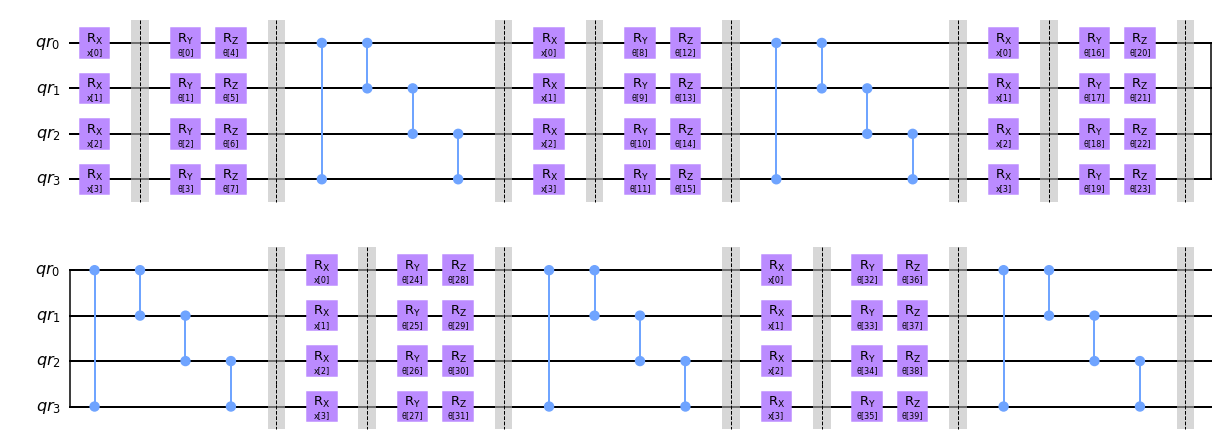

In [4]:
# Select the number of qubits
num_qubits = 4

# Generate the Parametrized Quantum Circuit (note the flag reuploading)
qc = parametrized_circuit(num_qubits = num_qubits, 
                          reuploading = True, 
                          reps = 5)

# Fetch the parameters from the circuit and divide them in Inputs (X) and Trainable Parameters (params)
# Note that the strange division is due to how Qiskit orders the parameters, check for yourself that 
# X actually contains parameters 'x' used for the inputs of the circuit. 
X = list(qc.parameters)[: num_qubits]
params = list(qc.parameters)[num_qubits:]

qc.draw()

Use `Qiskit`'s brand new `CircuitQNN` and `TorchConnector` modules to create a `PyTorch` model from the parametrized quantum circuit. 

In [5]:
qi_qasm = QuantumInstance(qk.Aer.get_backend('qasm_simulator'))
qi = QuantumInstance(qk.Aer.get_backend('statevector_simulator'))

qnn = CircuitQNN(qc, input_params=X, weight_params=params, 
                 quantum_instance = qi)

# set up PyTorch module
initial_weights = (2*np.random.rand(qnn.num_weights) - 1)
quantum_nn = TorchConnector(qnn, initial_weights)

## Classical pre and post processing layers  

As stated in the paper, for the model to function properly, classical pre- and post-processing layers are needed. Both of these will contains parameters hence will be trainable and optimized duirng the draining of the model.  

We define such layers as classes inheriting from `PyTorch`'s `torch.nn.Module`.  

#### `encoding_layer`  

First, we define the pre-processing (*encoding*) layer, which takes the classical inputs $\vec{x}= (x_0, x_1, x_2, x_3)$, multiplies them by a trainable parameters $\vec{w}= (w_0, w_1, w_2, w_3)$, and then applies an $\arctan$ on it, thus leading to the final transformation:  

$$ 
\vec{x} \rightarrow \vec{x}' = (x'_0, x'_1, x'_2, x'_3)\quad
{\rm{with}}\quad x'_i = \arctan(w_i \cdot x_i)\, .
$$  

In [6]:
class encoding_layer(torch.nn.Module):
    def __init__(self, num_qubits = 4):
        super().__init__()
        
        # Define weights for the layer
        weights = torch.Tensor(num_qubits)
        self.weights = torch.nn.Parameter(weights)
        torch.nn.init.uniform_(self.weights, -1, 1) # <--  Initialization strategy
    
        
    def forward(self, x):
        """Forward step, as explained above."""
        
        if not isinstance(x, Tensor):
            x = Tensor(x)
        # if len(x.shape) == 1: # Not needed, may cause problems
        #    x = torch.unsqueeze(x, 0)
        
        x = self.weights * x
        x = torch.atan(x)
                
        return x

#### `exp_val_layer`
Then, we create a the post-processing layer, which takes as input the output of the quantum circuit $\vec{p} = (p_0, p_1,\cdots, p_{16})$, consisting of the vector of outcomes probabilities of size $2^{\rm n\_qubits}$ (one entry per computational basis' state).  
> Using Qiskit's ordering of the qubits, $p_0$ corresponds to the probability of measuring state $|0000\rangle$, $p_1$ probability of measuring state $|0001\rangle$, and so on up until $p_{16}$ corresponding to the probability of measuring $|1111\rangle$.   

Given these probabilities, the `exp_val_layer` evaluates the expectation values $\langle Z_0 Z_1\rangle$ and $\langle Z_2 Z_3\rangle$, corresponding to the Q-values of the two possible actions $a$: "*left* or "*right*". At last, such values are shifted in $[0,1]$ and multiplied by a trainable weight each. 

#### Technical details 
The math behind this layer is as follows. $O_a$ is the operator corresponding to the action $a$, which are taken to be $O_{\rm left} = Z_0 Z_1$ and $O_{\rm right} = Z_2 Z_3$.  
> By $Z_0 Z_1$ we mean the Pauli Operator $Z$ acting of qubits '0' and '1', and identities on the other qubits, i.e the operator $Z_0 Z_1 \leftarrow Z_0 \otimes Z_1 \otimes \mathbb{1}_2 \otimes \mathbb{1}_3$. Same goes for $Z_3 Z_4$.  

The Q-values $Q(s, a)$ of action $a$ given a state $s$ is given by:

$$
Q(s, a) = w_{a}\cdot \frac{\langle \boldsymbol{0} | U_{\theta}(\vec{s})^\dagger O_a U_{\theta}(\vec{s}) |\boldsymbol{0}\rangle +1}{2}
$$

So the outcome of the `exp_val_layer` consists of the couple $\big[Q(s, a = {\rm left}),\, Q(s, a = {\rm right})\big]$. 

In order to go from the vector of probabilities $\vec{p}$ to the expectation values $\langle Z_0 Z_1\rangle$ and $\langle Z_2 Z_3\rangle$, one can do the following. Be $|\psi\rangle$ the state created by the PQC, on which we evaluate the mean vales. Then  

$$
\langle Z_j Z_k\rangle = \langle \psi |Z_j Z_k \mathbb{1}|\psi\rangle = \sum_{i = 0}^{15} \langle \psi |\underbrace{Z_j Z_k |i\rangle}_{ = f_{kj}(i)|i\rangle}\langle i |\psi\rangle = \sum_{i=0}^{15}f_{kj}(i)|\langle i | \psi \rangle |^2 = \sum_{i=0}^{15}f_{jk}(i) \cdot p_i\,
$$

where $f_{jk}(i)$ is given by  

$$
Z_j Z_k |i\rangle = Z_j Z_k |i_3 i_2 i_1 i_0\rangle = (-)^{i_j}(-)^{i_k}|i_3 i_2 i_1 i_0\rangle = (-)^{i_j+i_k}|i\rangle \quad \big(\text{NOTE: Qiskit ordering is being used!}\big)\\
\implies \langle Z_j Z_k\rangle = \sum_{i} (-)^{i_j + i_k} p_i
$$

One can check manually that (using `Qiskit` *little endian* ordering of the qubits):  

$$
Z_0 Z_1 \rightarrow \vec{f}_{01} = (1,-1,-1,1,1,-1,-1,1,1,-1,-1,1,1,-1,-1,1)\\
Z_2 Z_3 \rightarrow \vec{f}_{23} = (-1,-1,-1,-1,1,1,1,1,-1,-1,-1,-1,1,1,1,1)
$$


In [7]:
class exp_val_layer(torch.nn.Module):
    def __init__(self, action_space = 2):
        super().__init__()
        
        # Define the weights for the layer
        weights = torch.Tensor(action_space)
        self.weights = torch.nn.Parameter(weights)
        torch.nn.init.uniform_(self.weights, 35, 40) # <-- Initialization strategy (heuristic choice)
        
        # Check that these masks take the vector of probabilities to <Z_0*Z_1> and <Z_2*Z_3>
        self.mask_ZZ_12 = torch.tensor([1.,-1.,-1.,1.,1.,-1.,-1.,1.,1.,-1.,-1.,1.,1.,-1.,-1.,1.], requires_grad = False)
        self.mask_ZZ_34 = torch.tensor([-1.,-1.,-1.,-1.,1.,1.,1.,1.,-1.,-1.,-1.,-1.,1.,1.,1.,1.], requires_grad = False)
        
    def forward(self, x):
        """Forward step, as described above."""
        
        
        expval_ZZ_12 = self.mask_ZZ_12 * x
        expval_ZZ_34 = self.mask_ZZ_34 * x

        if len(x.shape) == 1:
            expval_ZZ_12 = torch.sum(expval_ZZ_12)#, dim = 1, keepdim = True)
            expval_ZZ_34 = torch.sum(expval_ZZ_34)#, dim = 1, keepdim = True)
            out = torch.cat((expval_ZZ_12.unsqueeze(0), expval_ZZ_34.unsqueeze(0)))
        else:
            expval_ZZ_12 = torch.sum(expval_ZZ_12, dim = 1, keepdim = True)
            expval_ZZ_34 = torch.sum(expval_ZZ_34, dim = 1, keepdim = True)
            out = torch.cat((expval_ZZ_12, expval_ZZ_34), 1)
                
        return self.weights * ((out + 1.) / 2.)

## Deep Q-network  

Now we proceed by creating the neural network (quantum + classical) to be trained to solve the Reinforcement Learning task.  

First, let's define the `OpenAI Gym` environment, in particular `CartPole-v1`:

In [8]:
env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

This code is used to create memories of the past experiences for the agents, which are used during the training of the agent.

In [9]:
from collections import deque

replay_memory = deque(maxlen=2000)

### Training Functions  

Here we define the functions for the classical Reinforcement Learning algorithm. This is based of the implementation pointed above at the start of the Notebook.

In [10]:
#### OLD FUNCTIONS (IGNORE) ####
#def epsilon_greedy_policy(state, epsilon=0):
#    if np.random.rand() < epsilon:
#        return np.random.randint(n_outputs)
#    else:
#        with torch.no_grad():
#            Q_values = model(Tensor(state)).numpy() # Remove Tensor
#        return np.argmax(Q_values[0])
#
#def sample_experiences(batch_size):
#    indices = np.random.randint(len(replay_memory), size=batch_size)
#    batch = [replay_memory[index] for index in indices]
#    states, actions, rewards, next_states, dones = [
#        np.array([experience[field_index] for experience in batch])
#        for field_index in range(5)]
#    return states, actions, rewards, next_states, dones
#
#def play_one_step(env, state, epsilon):
#    action = epsilon_greedy_policy(state, epsilon)
#    next_state, reward, done, info = env.step(action)
#    replay_memory.append((state, action, reward, next_state, done))
#    return next_state, reward, done, info
#
#def training_step(batch_size):
#    experiences = sample_experiences(batch_size)
#    states, actions, rewards, next_states, dones = experiences
#    
#    with torch.no_grad():
#        next_Q_values = model(Tensor(next_states)).numpy() # Remove Tensor
#        
#    max_next_Q_values = np.max(next_Q_values, axis=1)
#    target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)
#    target_Q_values = target_Q_values.reshape(-1, 1) # Not needed if loss is calculated per sample
#    
#    # NEW ROUTINE
#    #loss = 0.0
#    #for j in range(batch_size):
#    #    q_value = model(Tensor(states[j])) # Remove Tensor
#    #    q_value = q_value[actions[j]] # q_value[0, actions[j]]
#    #    loss += (torch.tensor(target_Q_values[j])**2 - q_value**2) / batch_size
#    #
#    #model.zero_grad()
#    #loss.backward()
#    #
#    #optimizer.step()
#    
#    # OLD ROUTINE 
#    mask = torch.nn.functional.one_hot(Tensor(actions).long(), n_outputs)
#    # print("qui")
#    
#    all_Q_values = model((Tensor(states)))
#    # print("allQ:",all_Q_values)
#    # print("mask:",mask)
#    Q_values = torch.sum(all_Q_values * mask, dim=1, keepdims=True)
#    #print("taget_q:",target_Q_values)
#    #print("qval:",Q_values)
#    loss = loss_fn(Tensor(target_Q_values), Q_values)
#    
#    optimizer.zero_grad()
#    loss.backward()
#
#    optimizer.step()

In [11]:
#### NEW FUNCTIONS #####

def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        with torch.no_grad():
            Q_values = model(Tensor(state[np.newaxis])).numpy()
        return np.argmax(Q_values[0])
    
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

def sequential_training_step(batch_size):
    # Use this training on the quantum model otherwise vanishing gradients. 
    # If possible, double check that this method and the one below gives same results.
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    
    # Evaluates the Target Q-values
    with torch.no_grad():
        next_Q_values = model(Tensor(next_states)).numpy()
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)
    
    # Accumulate Loss (this is the only way it works. If batching data, gradients are vanishing)
    loss = 0.
    for j, state in enumerate(states):
        single_Q_value = model(Tensor(state))
        Q_value = single_Q_value[actions[j]]
        loss += (target_Q_values[j] - Q_value)**2
    
    optimizer.zero_grad()
    loss.backward()
    #print(model[0].weights.grad)
    #print(model[1].weights.grad)
    #print(model[2].weights.grad)
    optimizer.step()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    with torch.no_grad():
        next_Q_values = model(Tensor(next_states)).numpy()
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = torch.nn.functional.one_hot(Tensor(actions).long(), n_outputs)
    
    all_Q_values = model(Tensor(states))
    Q_values = torch.sum(all_Q_values * mask, dim=1, keepdims=True)
    loss = loss_fn(Tensor(target_Q_values), Q_values)
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

### Final model  

We construct the final hybrid classical-quantum neural network by stacking together the three layers:  
`model` = `encoding_layer` --> `quantum_layer` --> `exp_val_layer`

In [12]:
encoding = encoding_layer()
exp_val = exp_val_layer()

model = torch.nn.Sequential(encoding, 
                            quantum_nn, 
                            exp_val)

model.state_dict()

OrderedDict([('0.weights', tensor([ 0.7645,  0.8300, -0.2343,  0.9186])),
             ('1._weights',
              tensor([-0.2509,  0.9014,  0.4640,  0.1973, -0.6880, -0.6880, -0.8838,  0.7324,
                       0.2022,  0.4161, -0.9588,  0.9398,  0.6649, -0.5753, -0.6364, -0.6332,
                      -0.3915,  0.0495, -0.1361, -0.4175,  0.2237, -0.7210, -0.4157, -0.2673,
                      -0.0879,  0.5704, -0.6007,  0.0285,  0.1848, -0.9071,  0.2151, -0.6590,
                      -0.8699,  0.8978,  0.9313,  0.6168, -0.3908, -0.8047,  0.3685, -0.1197])),
             ('2.weights', tensor([36.9522, 38.0045]))])

#### Fully classical model

In [120]:
model = torch.nn.Sequential(torch.nn.Linear(4,32),
                            torch.nn.ELU(),
                            torch.nn.Linear(32,32),
                            torch.nn.ELU(),
                            torch.nn.Linear(32,2))

model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.2434,  0.2936,  0.4408, -0.3668],
                      [ 0.4346,  0.0936,  0.3694,  0.0677],
                      [ 0.2411, -0.0706,  0.3854,  0.0739],
                      [-0.2334,  0.1274, -0.2304, -0.0586],
                      [-0.2031,  0.3317, -0.3947, -0.2305],
                      [-0.1412, -0.3006,  0.0472, -0.4938],
                      [ 0.4516, -0.4247,  0.3860,  0.0832],
                      [-0.1624,  0.3090,  0.0779,  0.4040],
                      [ 0.0547, -0.1577,  0.1343, -0.1356],
                      [ 0.2104,  0.4464,  0.2890, -0.2186],
                      [ 0.2886,  0.0895,  0.2539, -0.3048],
                      [-0.4950, -0.1932, -0.3835,  0.4103],
                      [ 0.1440,  0.2071,  0.1581, -0.0087],
                      [ 0.3913, -0.3553,  0.0315, -0.3413],
                      [ 0.1542, -0.1722,  0.1532, -0.1042],
                      [ 0.4147, -0.2964, -0.2982, -0.2982],
              

In [121]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

1282

In [122]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

1282

#### Define hyperparameters  

Define some hyperparameters, optimizer to be used, and loss function (*this is not used actually*).

In [13]:
batch_size = 16
discount_rate = 0.99
optimizer = Adam(model.parameters(), lr=1e-2)
loss_fn = MSELoss(reduction = "mean") # Not used at the moment

optimizer.__dict__

{'defaults': {'lr': 0.01,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False},
 '_zero_grad_profile_name': 'Optimizer.zero_grad#Adam.zero_grad',
 'state': defaultdict(dict, {}),
 'param_groups': [{'params': [Parameter containing:
    tensor([ 0.7645,  0.8300, -0.2343,  0.9186], requires_grad=True),
    Parameter containing:
    tensor([-0.2509,  0.9014,  0.4640,  0.1973, -0.6880, -0.6880, -0.8838,  0.7324,
             0.2022,  0.4161, -0.9588,  0.9398,  0.6649, -0.5753, -0.6364, -0.6332,
            -0.3915,  0.0495, -0.1361, -0.4175,  0.2237, -0.7210, -0.4157, -0.2673,
            -0.0879,  0.5704, -0.6007,  0.0285,  0.1848, -0.9071,  0.2151, -0.6590,
            -0.8699,  0.8978,  0.9313,  0.6168, -0.3908, -0.8047,  0.3685, -0.1197],
           requires_grad=True),
    Parameter containing:
    tensor([36.9522, 38.0045], requires_grad=True)],
   'lr': 0.01,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False}]}

#### Training starts

In [ ]:
rewards = [] 
best_score = 0

for episode in range(400):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 200, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step >= best_score: # Not shown
        best_weights = model.state_dict # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps : {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        sequential_training_step(batch_size)

#model.set_weights(best_weights)

Episode: 127, Steps : 58, eps: 0.3655

In [14]:
model[0].weights.grad

tensor([-3.8348e-07, -6.1112e-08,  1.2937e-07,  1.3687e-06])

In [15]:
model[1].weights.grad

tensor([-2.4028e-07,  0.0000e+00,  5.7369e-07,  1.3039e-08, -6.3330e-08,
         5.5879e-08, -3.6508e-07,  2.3469e-07,  4.0978e-08,  1.4715e-07,
         6.7055e-07, -4.0978e-07, -8.9407e-08, -3.0175e-07, -3.7998e-07,
        -3.8976e-07,  2.7940e-07,  4.4331e-07,  2.6636e-07, -5.2527e-07,
        -3.0175e-07, -3.0547e-07,  3.1665e-07, -2.6822e-07,  2.9802e-08,
        -1.1921e-07,  2.5891e-07,  6.3609e-07,  8.9407e-08,  4.7497e-08,
         4.0233e-07,  1.7136e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.6941e-21])

In [16]:
model[2].weights.grad

tensor([-0.9495,  0.3914])

In [ ]:
# These are optimal weights obtained with the training on 600 episodes, batch 16, lr = 1e-2, and
# probably a vanishing gradient loss function
opt_weights = OrderedDict([('0.weights', tensor([ 0.8229,  0.6987, -0.3140,  1.1798])),
             ('1._weights',
              tensor([-0.2359,  1.0064,  0.7440,  0.0314, -1.1688, -0.6151, -0.6669,  0.6689,
                       0.2252,  0.4455, -1.1998,  0.9438,  0.6029, -0.5056, -0.5781, -0.4501,
                      -0.5438,  0.1153,  0.0515, -0.4657,  0.1187, -0.8237, -0.2902, -0.4010,
                       0.1199,  0.3153, -0.3995,  0.2988,  0.3378, -0.8388,  0.2970, -0.6015,
                      -0.9951,  0.8411,  1.1244,  0.3238, -0.3908, -0.8047,  0.3685, -0.1197])),
             ('2.weights', tensor([40.1335, 39.2579]))])

In [17]:
model.state_dict()

OrderedDict([('0.weights', tensor([ 0.8229,  0.6987, -0.3140,  1.1798])),
             ('1._weights',
              tensor([-0.2359,  1.0064,  0.7440,  0.0314, -1.1688, -0.6151, -0.6669,  0.6689,
                       0.2252,  0.4455, -1.1998,  0.9438,  0.6029, -0.5056, -0.5781, -0.4501,
                      -0.5438,  0.1153,  0.0515, -0.4657,  0.1187, -0.8237, -0.2902, -0.4010,
                       0.1199,  0.3153, -0.3995,  0.2988,  0.3378, -0.8388,  0.2970, -0.6015,
                      -0.9951,  0.8411,  1.1244,  0.3238, -0.3908, -0.8047,  0.3685, -0.1197])),
             ('2.weights', tensor([40.1335, 39.2579]))])

In [ ]:
with torch.no_grad():
    model.weight = best_weights

#### Plot of total reward over the episodes

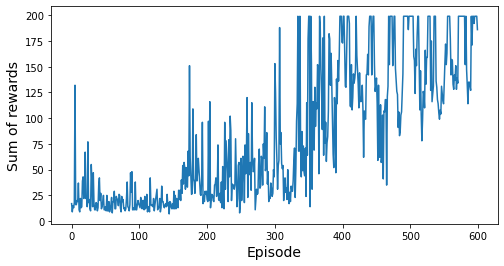

In [125]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
#save_fig("dqn_rewards_plot")
plt.show()

#### Animation with the trained agent

In [ ]:
# env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    print(action, state, model(Tensor([state])))
    if done:
        print("End at step:", step)
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

#### Predictions

# Tests (Ignore)

In [171]:
state = np.array([1,2,3,4])
state[np.newaxis]

array([[1, 2, 3, 4]])

In [140]:
p_dict = {}
for i in range(qnn.num_weights):
    p_dict[params[i]] = 0
    
x_dict = {}
for i in range(qnn.num_inputs):
    x_dict[X[i]] = 0.5

all_dict = {**p_dict, **x_dict}

cc = qnn.circuit
cc = cc.assign_parameters(all_dict)

r = qk.execute(cc, backend = qk.Aer.get_backend("statevector_simulator")).result().get_statevector()
np.abs(r)**2 

array([0.15063374, 0.00964634, 0.00964634, 0.00078855, 0.00964634,
       0.23769898, 0.00078855, 0.04040915, 0.00964634, 0.00078855,
       0.23769898, 0.04040915, 0.00078855, 0.04040915, 0.04040915,
       0.17059212])

In [134]:
init_weights = np.ones(qnn.num_weights)
qnn2 = TorchConnector(qnn, init_weights)

print(qnn2.state_dict())
print(qnn2.weights.grad)

OrderedDict([('_weights', tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]))])
None


In [345]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

s = env.reset()
for i in range(10):
    play_one_step(env, s, 1)

In [346]:
batch_size = 2
experiences = sample_experiences(batch_size)
states, actions, rewards, next_states, dones = experiences
with torch.no_grad():
    next_Q_values = qnn2(Tensor(next_states)).numpy()
max_next_Q_values = np.max(next_Q_values, axis=1)

target_Q_values = (rewards +
                   (1 - dones) * discount_rate * max_next_Q_values)
#target_Q_values = target_Q_values.reshape(-1, 1)
target_Q_values

array([1.37200738, 1.21729629])

In [327]:
single_Q_value = qnn2(Tensor(state))
ZZ_1 = m1 * single_Q_value
ZZ_1 = torch.sum(ZZ_1)#, dim = 1)#, keepdim = True)
ZZ_2 = m2 * single_Q_value
ZZ_2 = torch.sum(ZZ_2)#, dim = 1)#, keepdim = True)  
single_Q_value = torch.cat((ZZ_1.unsqueeze(0), ZZ_2.unsqueeze(0)))

print(ZZ_1, ZZ_2, single_Q_value)

tensor(0.3078, grad_fn=<SumBackward0>) tensor(-0.1858, grad_fn=<SumBackward0>) tensor([ 0.3078, -0.1858], grad_fn=<CatBackward>)


In [428]:
anna = CircuitQNN(qc, quant)

AttributeError: 'NoneType' object has no attribute 'configuration'

In [427]:
qnn.input_gradients(qnn)

TypeError: 'int' object is not callable

In [420]:
qnn.carlomaria = True
qnn.carlomaria

True

In [396]:
x = encoding(states[0])
y = quantum_nn(x)
z = exp_val(y)
loss = torch.sum(z)
print(loss)

encoding.zero_grad()
quantum_nn.zero_grad()
exp_val.zero_grad()
loss.backward()

tensor(0.6624, grad_fn=<SumBackward0>)


In [383]:
quantum_nn.weights.grad

tensor([ 3.1947e-01,  5.7449e-02,  2.7997e-01,  8.4917e-02,  6.1021e-03,
         4.1587e-02,  5.2563e-02,  6.6071e-02,  5.9163e-02,  8.3928e-02,
         2.5436e-01, -8.7007e-02, -2.0925e-02,  6.8407e-02,  4.8834e-02,
         3.0958e-02,  2.2532e-01, -2.5392e-02,  1.9269e-01,  7.1834e-02,
         4.2042e-02,  3.3071e-02,  1.4223e-02,  6.6279e-02, -2.1119e-02,
         2.8874e-02,  1.6517e-01, -1.6773e-01,  7.4497e-02, -3.3248e-02,
         9.7416e-03,  0.0000e+00,  3.3807e-01, -9.4989e-02,  9.4061e-02,
         0.0000e+00,  6.2884e-18,  0.0000e+00, -3.2526e-18, -2.6183e-17])

In [380]:
loss = 0.
for j, state in enumerate(states[:1]):
    # print("Start:", j, state)
    # single_Q_value = qnn2(Tensor(state))
    # ZZ_1 = m1 * single_Q_value
    # ZZ_1 = torch.sum(ZZ_1)#, dim = 1)#, keepdim = True)
    # ZZ_2 = m2 * single_Q_value
    # ZZ_2 = torch.sum(ZZ_2)#, dim = 1)#, keepdim = True)  
    # single_Q_value = torch.cat((ZZ_1.unsqueeze(0), ZZ_2.unsqueeze(0)))
    
    single_Q_value = model(state)
    loss = torch.sum(single_Q_value)
    print(loss, single_Q_value)
    
    # Q_value = single_Q_value[actions[j]]
    
    # loss += target_Q_values[j]**2 - Q_value**2

model.zero_grad()
loss.backward()

tensor(0.6624, grad_fn=<SumBackward0>) tensor([0.4686, 0.1939], grad_fn=<MulBackward0>)


In [382]:
print(model[1].weights.grad)

tensor([ 3.1947e-01,  5.7449e-02,  2.7997e-01,  8.4917e-02,  6.1021e-03,
         4.1587e-02,  5.2563e-02,  6.6071e-02,  5.9163e-02,  8.3928e-02,
         2.5436e-01, -8.7007e-02, -2.0925e-02,  6.8407e-02,  4.8834e-02,
         3.0958e-02,  2.2532e-01, -2.5392e-02,  1.9269e-01,  7.1834e-02,
         4.2042e-02,  3.3071e-02,  1.4223e-02,  6.6279e-02, -2.1119e-02,
         2.8874e-02,  1.6517e-01, -1.6773e-01,  7.4497e-02, -3.3248e-02,
         9.7416e-03,  0.0000e+00,  3.3807e-01, -9.4989e-02,  9.4061e-02,
         0.0000e+00,  6.2884e-18,  0.0000e+00, -3.2526e-18, -2.6183e-17])


In [283]:
ZZ_1 = m1 * all_Q_values
ZZ_1 = torch.sum(ZZ_1, dim = 1)#, keepdim = True)
ZZ_2 = m2 * all_Q_values
ZZ_2 = torch.sum(ZZ_2, dim = 1)#, keepdim = True)  
all_Q_values = torch.cat((ZZ_1, ZZ_2))

ValueError: operands could not be broadcast together with shapes (16,) (2,) 

In [258]:
Q_values = torch.sum(all_Q_values * mask, dim=1, keepdims=True)
Q_values

tensor([[-0.3095],
        [ 0.4971]], grad_fn=<SumBackward1>)

In [257]:
target_Q_values= Tensor(target_Q_values)
target_Q_values

tensor(1.1773)

In [256]:
loss = 0.
for j in range(batch_size):
    loss += (target_Q_values[j]**2 - all_Q_values[j]**2)
qnn2.zero_grad()
loss.backward()

print(qnn2.weights.grad)

RuntimeError: grad can be implicitly created only for scalar outputs

In [191]:
def training_step_sequential(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    with torch.no_grad():
        next_Q_values = qnn2(Tensor(next_states)).numpy()
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = torch.nn.functional.one_hot(Tensor(actions).long(), n_outputs)
    
    all_Q_values = qnn2(Tensor(states))
    Q_values = torch.sum(all_Q_values * mask, dim=1, keepdims=True)
    target_Q_values= Tensor(target_Q_values)
    loss = 0.
    for sample in range(batch_size):
        loss += (target_Q_values[i, 0]**2 - all_Q_values[i,0]**2) + (target_Q_values[i, 1]**2 - all_Q_values[i,1]**2)
    
    optimizer.zero_grad()
    loss.backward()
    # optimizer.step()

In [209]:
targ = torch.tensor([[10, 20], [20, 30]])

# Check that these masks take the vector of probabilities to <Z_0*Z_1> and <Z_2*Z_3>
m1 = torch.tensor([1.,-1.,-1.,1.,1.,-1.,-1.,1.,1.,-1.,-1.,1.,1.,-1.,-1.,1.], requires_grad = False)
m2 = torch.tensor([-1.,-1.,-1.,-1.,1.,1.,1.,1.,-1.,-1.,-1.,-1.,1.,1.,1.,1.], requires_grad = False)

x = Tensor([[0.5,0.5,0.5,0.5], [0.5,0.5,0.5,0.5]])
x = qnn2(x)

ZZ_1 = m1 * x
ZZ_1 = torch.sum(ZZ_1, dim = 1, keepdim = True)
ZZ_2 = m2 * x
ZZ_2 = torch.sum(ZZ_2, dim = 1, keepdim = True)  

out = torch.cat((ZZ_1, ZZ_2), 1)


loss = 0.
for i in range(2):
    print(targ[i, 0], out[i, 0], targ[i, 1], out[i, 1])
    loss += (targ[i, 0]**2 - out[i, 0] ** 2) + (targ[i, 1]**2 - out[i, 1]**2)
    print(loss)

optimizer.zero_grad()    
loss.backward()

print(qnn2.weights.grad)

tensor(10) tensor(0.3770, grad_fn=<SelectBackward>) tensor(20) tensor(-0.2569, grad_fn=<SelectBackward>)
tensor(499.7919, grad_fn=<AddBackward0>)
tensor(20) tensor(0.3770, grad_fn=<SelectBackward>) tensor(30) tensor(-0.2569, grad_fn=<SelectBackward>)
tensor(1799.5837, grad_fn=<AddBackward0>)
tensor([ 5.1432e-01,  1.0965e-01,  1.1405e-01,  1.6593e-01,  1.1585e+00,
         3.1577e-01,  4.0971e-01,  4.2263e-01, -7.6770e-01, -1.7013e-01,
        -2.2341e-01, -1.7273e-01,  5.9298e-01, -5.7855e-01, -6.8661e-02,
        -5.0864e-01, -3.1878e-01,  1.4778e-01,  2.5333e-01,  1.3710e-01,
         4.6917e-02, -2.9549e-01,  2.1344e-01, -3.1856e-01, -9.0469e-02,
        -4.2047e-01, -3.4055e-01, -3.4002e-01,  3.5762e-02,  3.5762e-02,
         7.7160e-01,  5.1411e-09, -2.2207e-02, -2.2207e-02, -2.9706e-01,
         1.5923e-08,  1.9010e-17, -1.2399e-16,  1.4806e-16, -2.9277e-17])


In [210]:
(10**2 - 0.3770**2) + (20**2 - 0.2569**2)

499.79187339

In [203]:
out

tensor([[ 0.3770, -0.2569],
        [ 0.3770, -0.2569]], grad_fn=<CatBackward>)

In [165]:
targ = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
x = torch.tensor([0.5,0.5,0.5,0.5])
x = qnn2(x)
loss = (targ - x).pow(2)
loss = torch.sum(loss)
qnn2.zero_grad()
loss.backward()
print(qnn2.weights.grad)

tensor([ 7.5303e-02,  7.5303e-02,  7.5303e-02,  7.5303e-02,  1.9032e-01,
         1.9032e-01,  1.9032e-01,  1.9032e-01, -1.8636e-01, -1.8636e-01,
        -1.8636e-01, -1.8636e-01, -9.3636e-02, -9.3636e-02, -9.3636e-02,
        -9.3636e-02,  2.1272e-02,  2.1272e-02,  2.1272e-02,  2.1272e-02,
        -9.4454e-02, -9.4454e-02, -9.4454e-02, -9.4454e-02,  6.0060e-02,
         6.0060e-02,  6.0060e-02,  6.0060e-02,  1.7535e-01,  1.7535e-01,
         1.7535e-01,  1.7535e-01, -8.7731e-02, -8.7731e-02, -8.7731e-02,
        -8.7731e-02,  6.4243e-17, -1.8254e-17,  5.8340e-17, -1.1600e-17])


In [155]:
x = Tensor([0.5,0.5,0.5,0.5])
x = qnn2(x)
loss = x[15]
loss.backward()
print(qnn2.weights.grad)

tensor([-2.6822e-02, -2.6822e-02, -2.6822e-02, -2.6822e-02, -6.1323e-02,
        -6.1323e-02, -6.1323e-02, -6.1323e-02,  5.1884e-02,  5.1884e-02,
         5.1884e-02,  5.1884e-02,  5.0465e-02,  5.0465e-02,  5.0465e-02,
         5.0465e-02, -1.9898e-02, -1.9898e-02, -1.9898e-02, -1.9898e-02,
         5.0465e-02,  5.0465e-02,  5.0465e-02,  5.0465e-02, -5.0037e-02,
        -5.0037e-02, -5.0037e-02, -5.0037e-02, -6.1323e-02, -6.1323e-02,
        -6.1323e-02, -6.1323e-02,  2.9088e-02,  2.9088e-02,  2.9088e-02,
         2.9088e-02,  1.7347e-18,  1.7000e-16, -8.0144e-16, -1.0842e-16])


In [61]:
torch.sum(x * m2)

tensor(-1.1921e-07, grad_fn=<SumBackward0>)

In [166]:
x = Tensor([0.5,0.5,0.5,0.5])
x = qnn2(x)

loss = torch.sum(m1 * x)

#ZZ_1 = torch.sum(ZZ_1, dim = 1, keepdim = True)
#ZZ_2 = m2 * x
#ZZ_2 = torch.sum(ZZ_2, dim = 1, keepdim = True)

# loss = (1 - x).pow(2).sum()

qnn2.zero_grad()
loss.backward(retain_graph = True)

In [167]:
print(qnn2.state_dict())
print(qnn2.weights.grad)

OrderedDict([('_weights', tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]))])
tensor([-1.0109e-01, -1.0109e-01,  1.2762e-01,  1.2762e-01, -1.1404e-01,
        -1.1404e-01,  3.2022e-01,  3.2022e-01, -1.4803e-01, -1.4803e-01,
        -1.5859e-01, -1.5859e-01, -3.6736e-02, -3.6736e-02,  2.4736e-01,
         2.4736e-01, -4.1262e-02, -4.1262e-02, -8.4656e-02, -8.4656e-02,
         1.9067e-01,  1.9067e-01,  9.6896e-02,  9.6896e-02, -3.6767e-01,
        -3.6767e-01, -4.0691e-02, -4.0691e-02,  1.4534e-01,  1.4534e-01,
         0.0000e+00,  0.0000e+00, -9.0252e-02, -9.0252e-02,  0.0000e+00,
         0.0000e+00, -9.1940e-17, -1.0408e-17,  6.5919e-17,  8.6736e-19])


In [44]:
x = Tensor([[1,2,3,4]])
x = qnn2(x)

ZZ_1 = m1 * x
ZZ_1 = torch.sum(ZZ_1, dim = 1, keepdim = True)
loss = (1-ZZ_1).pow(2).sum()
loss

tensor(2.0749, grad_fn=<SumBackward0>)

In [ ]:
experiences = sample_experiences(batch_size)
states, actions, rewards, next_states, dones = experiences

In [ ]:
for i in np.arange(0, 4,2):
    print(i)

In [ ]:
with torch.no_grad():
    next_Q_values = model(Tensor(next_states)).numpy()
max_next_Q_values = np.max(next_Q_values, axis=1)
target_Q_values = (rewards +
                   (1 - dones) * discount_rate * max_next_Q_values)
target_Q_values = target_Q_values.reshape(-1, 1)
mask = torch.nn.functional.one_hot(Tensor(actions).long(), n_outputs)
all_Q_values = model(Tensor(states))
Q_values = torch.sum(all_Q_values * mask, dim=1, keepdims=True)
loss = loss_fn(Tensor(target_Q_values), Q_values)

optimizer.zero_grad()
loss.backward(retain_graph = True)

print(Q_values, "\n\n", Tensor(target_Q_values), "\n", loss)
for i in np.arange(0,6,2):
    print("Pino:", model[i].weight.grad)

In [ ]:
model.train()

with torch.no_grad():
    next_Q_values = model(Tensor(next_states)).numpy() # Remove Tensor
    
max_next_Q_values = np.max(next_Q_values, axis=1)
target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)
target_Q_values = target_Q_values.reshape(-1, 1) # Not needed if loss is calculated per sample

loss = 0.0
for j in range(batch_size):
    q_value = model(Tensor(states[j])) # Remove Tensor
    print("nanni = ", q_value, q_value.squeeze(0))
    q_value = q_value.squeeze(0)[actions[j]] # q_value[0, actions[j]]
    loss = loss + (Tensor(target_Q_values[j]) - q_value) ** 2 / batch_size
    print(q_value, Tensor(target_Q_values[j]))
print(loss)

optimizer.zero_grad(set_to_none = True)
loss.backward(retain_graph = True)

for i in np.arange(0,6,2):
    print(model[i].weight.grad)

In [ ]:
env.reset()
state, *_ = env.step(0)

encoding = encoding_layer()
expval = exp_val_layer()

#state = encoding(state)
#probs = quantum_nn(state)
#qvalues = expval(probs)

model = torch.nn.Sequential(encoding, quantum_nn, expval)

batch_size = 5
discount_rate = 0.99
optimizer = Adam(model.parameters(), lr = 1e-2)
loss_fn = MSELoss()

for i in range(10):
    play_one_step(env, state, 1)

In [ ]:
experiences = sample_experiences(batch_size)
states, actions, rewards, next_states, dones = experiences
with torch.no_grad():
    next_Q_values = model(next_states).numpy()
    
max_next_Q_values = np.max(next_Q_values, axis=1)
target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)
# target_Q_values = target_Q_values.reshape(-1, 1) # Not needed if loss is calucaled per sample
#loss = 0.0
#for j in range(batch_size):
#    q_value = model(states[j])
#    q_value = q_value[0, actions[j]]
#    loss += (torch.tensor(target_Q_values[j]) - q_value).pow(2) / batch_size
q_values = model(states)
mask = torch.nn.functional.one_hot(Tensor(actions).long(), n_outputs)
Q_values = torch.sum(q_values * mask, dim=1, keepdims=True)
loss = loss_fn(Q_values, torch.tensor(target_Q_values))
model.zero_grad()
loss.backward()
#optimizer.step()

In [ ]:
for i in range(3):
    print(model[i].weights.grad)

In [ ]:
from torchviz import make_dot

In [ ]:
class exp_val_layer_v0(torch.nn.Module):
    def __init__(self, action_space = 2):
        super().__init__()
        
        # Define the weights for the layer
        weights = torch.Tensor(action_space)
        self.weights = torch.nn.Parameter(weights)
        torch.nn.init.uniform_(self.weights, 1, 90) # <-- Initialization strategy
        
        # Check that these masks take the vector of probabilities to <Z_0*Z_1> and <Z_2*Z_3>
        self.mask_ZZ_12 = torch.tensor([1.,-1.,-1.,1.,1.,-1.,-1.,1.,1.,-1.,-1.,1.,1.,-1.,-1.,1.])
        self.mask_ZZ_34 = torch.tensor([-1.,-1.,-1.,-1.,1.,1.,1.,1.,-1.,-1.,-1.,-1.,1.,1.,1.,1.])
        
    def forward(self, x):
        """Forward step, as described above."""
        
        # Probably uselsess
        #if len(x.shape) == 1:
        #    x = x.unsqueeze(0)
        
        x = x.float()
            
        expval_ZZ_12 = torch.tensordot(x, self.mask_ZZ_12, dims = 1).reshape(-1,1)
        expval_ZZ_34 = torch.tensordot(x, self.mask_ZZ_34, dims = 1).reshape(-1,1)
                        
        out = torch.cat((expval_ZZ_12, expval_ZZ_34),1)
                
        return self.weights * ((out + 1) / 2)
    
class exp_val_layer_v1(torch.nn.Module):
    def __init__(self, action_space = 2):
        super().__init__()
        
        # Define the weights for the layer
        weights = torch.Tensor(action_space)
        self.weights = torch.nn.Parameter(weights)
        torch.nn.init.uniform_(self.weights, 1, 90) # <-- Initialization strategy
        
        # Check that these masks take the vector of probabilities to <Z_0*Z_1> and <Z_2*Z_3>
        self.mask_ZZ_12 = torch.tensor([1.,-1.,-1.,1.,1.,-1.,-1.,1.,1.,-1.,-1.,1.,1.,-1.,-1.,1.])
        self.mask_ZZ_34 = torch.tensor([-1.,-1.,-1.,-1.,1.,1.,1.,1.,-1.,-1.,-1.,-1.,1.,1.,1.,1.])
        
    def forward(self, x):
        """Forward step, as described above."""
        
        
        expval_ZZ_12 = self.mask_ZZ_12 * x
        expval_ZZ_12 = torch.sum(expval_ZZ_12, dim = 1, keepdim = True)
        
        expval_ZZ_34 = self.mask_ZZ_34 * x
        expval_ZZ_34 = torch.sum(expval_ZZ_34, dim = 1, keepdim = True)
                                
        out = torch.cat((expval_ZZ_12, expval_ZZ_34), 1)
                
        return self.weights * ((out + 1) / 2)

In [ ]:
v1 = exp_val_layer_v1()
v0 = exp_val_layer_v0()
encoding = encoding_layer()

In [ ]:
v1(probs)

In [ ]:
m1 = torch.tensor([1.,-1.,-1.,1.,1.,-1.,-1.,1.,1.,-1.,-1.,1.,1.,-1.,-1.,1.])
m2 = torch.tensor([-1.,-1.,-1.,-1.,1.,1.,1.,1.,-1.,-1.,-1.,-1.,1.,1.,1.,1.])

x1 = m1 * probs
x2 = m2 * probs
print(x1)
print(x2)

In [ ]:
x3 = torch.sum(x1, dim = 1, keepdim = True)
x3

In [ ]:
x4 = torch.sum(x2, dim = 1, keepdim = True)
x4

In [ ]:
v1.state_dict()

In [ ]:
12.8346 * ((1 + -0.1861)/2)